In [1]:
import path
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns 
import pydot
import graphviz
import confusion_matrix as cmat
import preprocessing as pp

from sklearn.metrics import classification_report

In [2]:
np.random.seed(13)
tf.random.set_seed(13)

In [3]:
X_train, X_test, y_train, y_test, X_columns, y_columns = pp.load_data(suffix='no_measures')

In [4]:
# X_train, X_test, X_columns = pp.preprocess(return_arrays=True, save_as_file=True, y_goal_diff=False, suffix='result_no_measures')

In [5]:
# y_train, y_test, y_columns = pp.preprocess_y(save_as_file=True, y_goal_diff=False, suffix='no_measures')

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(list(X_columns.keys()))
print(list(y_columns.keys()))

(8995, 366, 12)
(2249, 366, 12)
(8995, 3)
(2249, 3)
['st_x', 'st_y', 'event_blocked_shot', 'event_faceoff', 'event_giveaway', 'event_hit', 'event_missed_shot', 'event_penalty', 'event_shot', 'event_takeaway', 'event_dummy', 'home_team_for']
['a_home_win', 'b_tie', 'c_away_win']


In [7]:
print(np.mean(y_train, axis=0))
print(np.mean(y_test, axis=0))

[0.42879377 0.23446359 0.33674263]
[0.41307248 0.24321921 0.34370831]


In [8]:
model_mlp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])
model_mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model_mlp.fit(X_train, y_train, epochs=10, validation_split=0.2)
model_mlp.evaluate(X_test, y_test, verbose=0)

Train on 7196 samples, validate on 1799 samples
Epoch 1/10
7196/7196 [==============================] - 4s 519us/sample - loss: 1.0974 - accuracy: 0.4108 - val_loss: 1.0533 - val_accuracy: 0.4825
Epoch 2/10
7196/7196 [==============================] - 4s 503us/sample - loss: 1.0071 - accuracy: 0.5147 - val_loss: 0.9874 - val_accuracy: 0.5425
Epoch 3/10
7196/7196 [==============================] - 4s 577us/sample - loss: 0.9311 - accuracy: 0.5710 - val_loss: 0.9614 - val_accuracy: 0.5497
Epoch 4/10
7196/7196 [==============================] - 4s 578us/sample - loss: 0.8834 - accuracy: 0.6016 - val_loss: 0.9561 - val_accuracy: 0.5803
Epoch 5/10
7196/7196 [==============================] - 4s 526us/sample - loss: 0.8488 - accuracy: 0.6181 - val_loss: 0.9325 - val_accuracy: 0.5731
Epoch 6/10
7196/7196 [==============================] - 3s 470us/sample - loss: 0.8228 - accuracy: 0.6351 - val_loss: 0.9225 - val_accuracy: 0.5792
Epoch 7/10
7196/7196 [==============================] - 3s 457us

[0.9667509851481131, 0.57581145]

In [10]:
results_mlp = model_mlp.evaluate(X_test, y_test, verbose=0)
y_pred_mlp = model_mlp.predict(X_test)

print("Test log-loss for feedforward network:", results_mlp[0])
print("Test accuracy for feedforward network:", results_mlp[1])

Test log-loss for feedforward network: 0.9667509851481131
Test accuracy for feedforward network: 0.57581145


In [11]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 366, 16)           208       
_________________________________________________________________
dense_1 (Dense)              (None, 366, 16)           272       
_________________________________________________________________
flatten (Flatten)            (None, 5856)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5856)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 17571     
Total params: 18,051
Trainable params: 18,051
Non-trainable params: 0
_________________________________________________________________


In [12]:
classes = ['home win', 'tie (OT/SO)', 'away win']

In [13]:
for i in range(y_pred_mlp.shape[1]):
    print("Predicted result " + classes[i] + ":\t", np.sum(y_pred_mlp.argmax(axis=1) == i))

Predicted result home win:	 1292
Predicted result tie (OT/SO):	 292
Predicted result away win:	 665


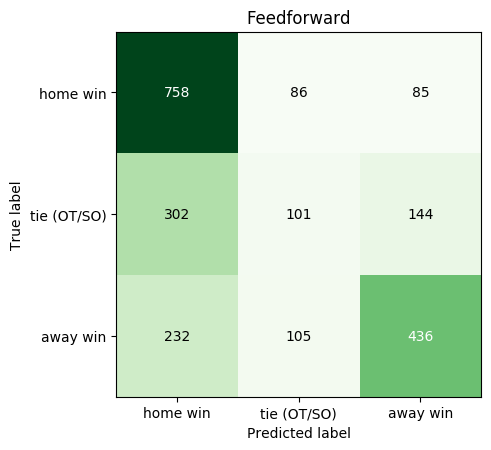

In [14]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(5,5))

cmat.plot(y_test, y_pred_mlp, classes=classes, normalize=False, title="Feedforward", show_colorbar=False, ax=ax)

fig.tight_layout()
fig.savefig('img/confusion_matrix_mlp.png')

plt.show()

In [15]:
print(classification_report(y_test.argmax(axis=1), y_pred_mlp.argmax(axis=1), target_names=classes))

precision    recall  f1-score   support

    home win       0.59      0.82      0.68       929
 tie (OT/SO)       0.35      0.18      0.24       547
    away win       0.66      0.56      0.61       773

    accuracy                           0.58      2249
   macro avg       0.53      0.52      0.51      2249
weighted avg       0.55      0.58      0.55      2249



In [16]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 12, activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv1D(32, 8, activation='relu'),
    tf.keras.layers.AveragePooling1D(3),
    tf.keras.layers.Conv1D(16, 6, activation='relu'),
    tf.keras.layers.Conv1D(16, 6, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model_cnn.fit(X_train, y_train, epochs=10, validation_split=0.2)
model_cnn.evaluate(X_test, y_test, verbose=2)

Train on 7196 samples, validate on 1799 samples
Epoch 1/10
7196/7196 [==============================] - 12s 2ms/sample - loss: 1.0789 - accuracy: 0.4208 - val_loss: 1.0697 - val_accuracy: 0.4347
Epoch 2/10
7196/7196 [==============================] - 10s 1ms/sample - loss: 1.0734 - accuracy: 0.4273 - val_loss: 1.0667 - val_accuracy: 0.4347
Epoch 3/10
7196/7196 [==============================] - 10s 1ms/sample - loss: 1.0683 - accuracy: 0.4284 - val_loss: 1.0491 - val_accuracy: 0.4375
Epoch 4/10
7196/7196 [==============================] - 11s 2ms/sample - loss: 1.0170 - accuracy: 0.5089 - val_loss: 0.9159 - val_accuracy: 0.5976
Epoch 5/10
7196/7196 [==============================] - 12s 2ms/sample - loss: 0.9034 - accuracy: 0.6119 - val_loss: 0.8706 - val_accuracy: 0.6120
Epoch 6/10
7196/7196 [==============================] - 12s 2ms/sample - loss: 0.8674 - accuracy: 0.6223 - val_loss: 0.8520 - val_accuracy: 0.6148
Epoch 7/10
7196/7196 [==============================] - 13s 2ms/sample

[0.8439713861211876, 0.6162739]

In [18]:
results_cnn = model_cnn.evaluate(X_test, y_test, verbose=0)
y_pred_cnn = model_cnn.predict(X_test)

print("Test log-loss for convolutional network:", results_cnn[0])
print("Test accuracy for convolutional network:", results_cnn[1])

Test log-loss for convolutional network: 0.8439713861211876
Test accuracy for convolutional network: 0.6162739


In [19]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 355, 64)           9280      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 348, 32)           16416     
_________________________________________________________________
average_pooling1d (AveragePo (None, 116, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 111, 16)           3088      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 106, 16)           1552      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

In [21]:
tf.keras.utils.plot_model(model_cnn, to_file='img/model_cnn_outcome.png')

InvocationException: GraphViz's executables not found

In [20]:
for i in range(len(classes)):
    print("Predicted result " + classes[i] + ":", np.sum(y_pred_cnn.argmax(axis=1) == i))

Predicted result home win: 1325
Predicted result tie (OT/SO): 11
Predicted result away win: 913


In [ ]:
print(classification_report(y_test.argmax(axis=1), y_pred_cnn.argmax(axis=1), target_names=classes))

In [ ]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(5,5))

cmat.plot(y_test, y_pred_cnn, classes=classes, normalize=False, title="Convolution", show_colorbar=False, ax=ax)

fig.tight_layout()
fig.savefig('img/confusion_matrix_cnn.png')

plt.show()

In [ ]:
game_stats = pd.read_csv("data/csv/game_teams_stats.csv")
id_test = np.load('data/no_measures/id/id_test.npy')

home = game_stats.loc[game_stats['HoA']=='home']
away = game_stats.loc[game_stats['HoA']=='away']
game_stats = home.merge(away, on='game_id', suffixes=['_home', '_away'])
game_stats = game_stats.loc[game_stats['game_id'].isin(id_test), :]

game_stats = game_stats.sort_values(by='game_id')

In [ ]:
def pdo(x):
    return 100*(x[0]/(x[2]+x[0]) + x[3]/(x[1]+x[3]))

In [ ]:
game_stats['pdo_home'] = game_stats.loc[:, ['goals_home', 'goals_away', 
                                            'shots_home', 'shots_away']].apply(pdo, axis=1)

game_stats['pdo_away'] = game_stats.loc[:, ['goals_away', 'goals_home', 
                                            'shots_away', 'shots_home']].apply(pdo, axis=1)

In [ ]:
game_stats['pred_result_mlp'] = y_pred_mlp.argmax(axis=1)[np.argsort(id_test)]
game_stats['pred_result_mlp'] = game_stats['pred_result_mlp'].replace([0, 1, 2], classes)

game_stats['pred_result_cnn'] = y_pred_cnn.argmax(axis=1)[np.argsort(id_test)]
game_stats['pred_result_cnn'] = game_stats['pred_result_cnn'].replace([0, 1, 2], classes)

In [ ]:
sns.set(style="whitegrid")

plt.subplots(figsize=(6,4))

sns.boxplot(x='pred_result_mlp', y='pdo_home', data=game_stats, order=classes)

plt.ylabel('Home team PDO', fontsize=16, labelpad=10)
plt.xlabel('Predicted result', fontsize=16, labelpad=10)
plt.title('Feedforward', fontsize=20)

plt.show()

In [ ]:
sns.set(style="whitegrid")

plt.subplots(figsize=(6,4))

sns.boxplot(x='pred_result_cnn', y='pdo_home', data=game_stats, order=classes)

plt.ylabel('Home team PDO', fontsize=16, labelpad=10)
plt.xlabel('Predicted result', fontsize=16, labelpad=10)
plt.title('Convolution', fontsize=20)

plt.show()